# Uso de Técnicas de Aprendizado de Máquina para a Predição do Tempo de Graduação dos Discentes de Engenharia da Computação na Região Sul do Brasil

In [1]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import glob
import os

In [2]:
#Importação da base de dados

caminho_diretorio = r"Microdados_Enade_2023\DADOS"

# Buscar todos os arquivos .csv com padrão especificado
arquivos = glob.glob(os.path.join(caminho_diretorio, "microdados2023_arq*.csv"))

dfs = []
colunas_existentes = set()

for arquivo in arquivos:
    df = pd.read_csv(arquivo, delimiter=";", encoding="latin1", low_memory=False)
    
    # Filtra apenas colunas ainda não adicionadas
    colunas_novas = [col for col in df.columns if col not in colunas_existentes]
    
    if colunas_novas:
        dfs.append(df[colunas_novas])
        colunas_existentes.update(colunas_novas)

# Concatena os dados horizontalmente (colunas diferentes, mesmas linhas)
df = pd.concat(dfs, axis=1)

# Filtrar por curso e região
df = df[
    (df["CO_GRUPO"] == 6411) & 
    (df["CO_REGIAO_CURSO"] == 4)
]

# Salva resultado
# df_final.to_csv(os.path.join(caminho_diretorio, "base_final.csv"), index=False, sep=";")

## Análise exploratória
### Amostra inicial

In [3]:
df.head()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,TP_SEXO,NU_IDADE,QE_I01,QE_I02,QE_I03
4360,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4361,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4362,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4363,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4364,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN


### Informações da base de dados

In [4]:
def info_completo(df):
    tabela = pd.DataFrame({
        'Tipo': df.dtypes,
        'Não Nulos': df.notnull().sum(),
        'Nulos': df.isnull().sum(),
        'Únicos': df.nunique()
    })
    display(tabela)
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
NU_ANO,int64,887,0,1
CO_CURSO,int64,887,0,33
CO_IES,int64,887,0,26
CO_CATEGAD,int64,887,0,4
CO_ORGACAD,int64,887,0,4
...,...,...,...,...
TP_SEXO,object,887,0,2
NU_IDADE,int64,887,0,16
QE_I01,object,865,22,3
QE_I02,object,865,22,4


### Resumo estatístico das variáveis

In [5]:
df.describe()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,NU_IDADE
count,887.0,8.870000e+02,887.000000,887.000000,887.000000,887.0,887.000000,8.870000e+02,887.000000,887.0,...,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,887.000000
mean,2023.0,8.892754e+05,1312.740699,3.216460,10025.001127,6411.0,0.684329,4.158298e+06,41.492672,4.0,...,5.350289,5.408092,5.262428,5.357225,5.611561,5.627746,5.619653,5.166474,5.42659,27.862458
std,0.0,5.532997e+05,1667.231131,2.391303,3.822087,0.0,0.465045,7.715309e+04,0.770288,0.0,...,1.204189,1.121622,1.286247,1.201184,0.917603,0.984918,0.896150,1.510774,1.23584,4.741777
min,2023.0,8.720000e+02,10.000000,1.000000,10020.000000,6411.0,0.000000,4.101408e+06,41.000000,4.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,21.000000
25%,2023.0,1.156160e+05,588.000000,1.000000,10020.000000,6411.0,0.000000,4.106902e+06,41.000000,4.0,...,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.00000,25.000000
50%,2023.0,1.155374e+06,588.000000,4.000000,10028.000000,6411.0,1.000000,4.106902e+06,41.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,26.000000
75%,2023.0,1.315345e+06,1491.000000,4.000000,10028.000000,6411.0,1.000000,4.204202e+06,42.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,30.000000
max,2023.0,1.537513e+06,14951.000000,8.000000,10028.000000,6411.0,1.000000,4.321808e+06,43.000000,4.0,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,50.000000


In [6]:
# Apagar registro de formandos que faltaram ao dia de aplicação do ENADE.

df = df[df["TP_PRES"] == 555]
df.shape

(865, 125)

In [7]:
# Apagando colunas consideradas desnecessárias

df = df.drop(columns=[
    'NU_ANO', 'CO_GRUPO', 'CO_MUNIC_CURSO', 'CO_REGIAO_CURSO',
    'NU_ITEM_OFG', 'NU_ITEM_OFG_Z', 'NU_ITEM_OFG_X', 'NU_ITEM_OFG_N',
    'NU_ITEM_OCE', 'NU_ITEM_OCE_Z', 'NU_ITEM_OCE_X', 'NU_ITEM_OCE_N',
    'DS_VT_GAB_OFG_FIN', 'DS_VT_GAB_OCE_FIN', 'DS_VT_ESC_OFG', 'DS_VT_ACE_OFG',
    'DS_VT_ESC_OCE', 'DS_VT_ACE_OCE', 'TP_PRES', 'TP_PR_GER', 'TP_PR_OB_FG',
    'TP_PR_DI_FG', 'TP_PR_OB_CE', 'TP_PR_DI_CE', 'TP_SFG_D1', 'TP_SCE_D1', 
    'QE_I03', 'QE_I12', 'QE_I13', 'QE_I14', 'QE_I15', 'QE_I16', 'QE_I18', 'QE_I19', 'QE_I24', 
])

In [8]:
# Criar classificação para tempo de formação

df["ANOS_CURS"] = 2023 - df["ANO_IN_GRAD"]

df["ANOS_CURS"] = pd.cut(df["ANOS_CURS"], bins=[-float('inf'), 5, float('inf')], labels=[1, 2]).astype(int)

In [9]:
df = df.drop(columns=["ANO_IN_GRAD", "ANO_FIM_EM"])

In [10]:
# Diminuir número de dimensões das variáveis de questionário

# Função para simplificar as respostas
def simplificar_opinioes(valor):
    if valor in [1, 2, 3]:
        return 1 #Discordo
    elif valor in [4, 5, 6]:
        return 2 #Concordo
    elif valor in [7, 8]:
        return 3 #Não sei
    else:
        return np.nan  # Para lidar com valores inesperados ou ausentes

# Lista das colunas de interesse (QE_I27 a QE_I68)
colunas_opinioes = [f'QE_I{i}' for i in range(27, 69) if f'QE_I{i}' in df.columns]

# Aplicar a transformação
for col in colunas_opinioes:
    df[col] = df[col].apply(simplificar_opinioes)


In [11]:
# Diminuir dimensões das váriaveis abaixo

# 1- Casado/ 2- Não casado
df['QE_I01'] = df['QE_I01'].apply(lambda x: 1 if x in ["B"] else 2)

# 1-branco e amarelo/ 2-preto, pardo e indígena
df['QE_I02'] = df['QE_I02'].apply(lambda x: 1 if x in ["A", "C"] else 2 if x in ["B", "D", "E"] else 3 if x in ["F"] else np.nan)

# 1- até o fundamental completo/ 2- ensino médio/ 3- ensino superior e pós
df['QE_I04'] = df['QE_I04'].apply(lambda x: 1 if x in ["A", "B", "C"] else 2 if x in ["D"] else 3 if x in ["E", "F"] else np.nan)

# 1- até o fundamental completo/ 2- ensino médio/ 3- ensino superior e pós
df['QE_I05'] = df['QE_I05'].apply(lambda x: 1 if x in ["A", "B", "C"] else 2 if x in ["D"] else 3 if x in ["E", "F"] else np.nan)

# 1- mora com pais ou parentes/ 2- Outras moradias
df['QE_I06'] = df['QE_I06'].apply(lambda x: 1 if x in ["B"] else 2)

# 1- Até uma pessoa/ 2- Duas/ 3- Três, 4- Quatro ou mais
df['QE_I07'] = df['QE_I07'].apply(lambda x: 1 if x in ["A", "B"] else 2 if x in ["C"] else 3 if x in ["D"] else 4 if x in ["E", "F", "G"] else np.nan)

# 1- Até 3 salários mínimos/ 2- Até 4,5 salários/ 3- Acima de 4,5 salários
df['QE_I08'] = df['QE_I08'].apply(lambda x: 1 if x in ["A", "B"] else 2 if x in ["C"] else 3 if x in ["D", "E", "F", "G"] else np.nan)

# 1- Gastos são financiados/ 2- Tem renda, mas recebe ajuda/ 3- Tem renda, mas não precisa de ajuda/ 4- Contribui para o sustento da família 
df['QE_I09'] = df['QE_I09'].apply(lambda x: 1 if x in ["A", "B"] else 2 if x in ["C"] else 3 if x in ["D"] else 4 if x in ["E", "F"] else np.nan)

# 1- Não trabalha/ 2- Trabalha até 39 horas semanais/ 3- Trabalha 40 horas ou mais
df['QE_I10'] = df['QE_I10'].apply(lambda x: 1 if x in ["A"] else 2 if x in ["B", "C", "D"] else 3 if x in ["E"] else 4 if x in ["E", "F"] else np.nan)

# 1- Nenhuma/ 2- Recebe
df['QE_I11'] = df['QE_I11'].apply(lambda x: 1 if x in ["A", "B"] else 2 )
df['QE_I11'] = df['QE_I11'].astype('Int64')

# 1- Total em escola pública/ 2- Parcial ou total em particular ou fora do Brasil
df['QE_I17'] = df['QE_I17'].apply(lambda x: 1 if x in ["A"] else 2 if x in ["B", "C", "D", "E", "F"]  else np.nan)

# 1- Apoio dos pais/ 2-Outros
df['QE_I20'] = df['QE_I20'].apply(lambda x: 1 if x in ["C"] else 2)

# 1- Sim/ 2- Não
df['QE_I21'] = df['QE_I21'].apply(lambda x: 1 if x in ["A"] else 2)

# 1- Até dois livros/2- Mais de dois
df['QE_I22'] = df['QE_I22'].apply(lambda x: 1 if x in ["A", "B"] else 2 if x in ["C", "D", "E"] else np.nan)

# 1- Até três horas/2- Quatro horas ou mais
df['QE_I23'] = df['QE_I23'].apply(lambda x: 1 if x in ["A", "B"] else 2)

# 1- Valorização profissional/ 2- Vocação/ 3- Outro
df['QE_I25'] = df['QE_I25'].apply(lambda x: 1 if x in ["C"] else 2 if x in ["E"] else 3)

# 1- Facilidades/ 2- Qualidade/reputação
df['QE_I26'] = df['QE_I26'].apply(lambda x: 1 if x in ["A", "B", "C", "D", "E", "G", "H", "I"] else 2 if x in ["F"] else np.nan)




In [12]:
# df["QE_I01"].value_counts()
# df['QE_I02'].value_counts()
# df['QE_I04'].value_counts()
# df['QE_I05'].value_counts()
# df['QE_I06'].value_counts()
# df['QE_I07'].value_counts()
# df['QE_I08'].value_counts()
# df['QE_I09'].value_counts()
# df['QE_I10'].value_counts()
# df['QE_I11'].value_counts()
# df['QE_I17'].value_counts()
# df['QE_I20'].value_counts()
# df['QE_I22'].value_counts()
# df['QE_I23'].value_counts()
# df['QE_I25'].value_counts()
# df['QE_I26'].value_counts()




In [13]:
# Gera a lista de sufixos a serem removidos
sufixos_para_remover = list(range(27, 40)) + list(range(42, 44)) + [45] + list(range(47, 52)) + list(range(54, 62)) + list(range(63, 67)) + [68]

# Constrói os nomes das colunas a serem removidas
colunas_para_remover = [f'QE_I{sufixo}' for sufixo in sufixos_para_remover]

# Remove as colunas que existem no DataFrame
df = df.drop(columns=[col for col in colunas_para_remover if col in df.columns])


In [14]:
# Codificação de variáveis categóricas

from sklearn.preprocessing import LabelEncoder

# Lista das colunas categóricas
colunas_categoricas = ['CO_CURSO', 'CO_IES', 'CO_CATEGAD', 'CO_ORGACAD', 'CO_MODALIDADE', 'CO_UF_CURSO', 'TP_SEXO']

# Aplicar LabelEncoder em cada uma
le = LabelEncoder()

for col in colunas_categoricas:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))


In [15]:
# Encoding de variáveis ordinais

# CO_RS_I1 a CO_RS_I9
mapeamento_ordem = {
    'A': 0,  
    'B': 1,  
    'C': 2,  
    'D': 3,  
    'E': 4,  
    '*': 5,  
    '.': 5,  
    '' : 5    
}

# Lista das colunas
colunas_rs = [f'CO_RS_I{i}' for i in range(1, 10)]

# Aplicar o mapeamento em cada uma
for col in colunas_rs:
    if col in df.columns:
        df[col] = df[col].map(mapeamento_ordem)


### Descrição dos dados após tratamento prévio

In [16]:
df.describe()

,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_MODALIDADE,CO_UF_CURSO,QE_I04,QE_I05,QE_I06,QE_I07,...,QE_I46,QE_I52,QE_I53,QE_I62,QE_I67,TP_SEXO,NU_IDADE,QE_I01,QE_I02,ANOS_CURS
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.000000,865.00000,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,865.000000,865.000000
mean,12.257803,14.099422,1.200000,1.852023,0.676301,0.505202,1.804624,2.338728,1.390751,2.363006,...,1.988439,1.89711,1.872832,1.921387,1.915607,0.478613,28.036994,1.92948,1.440462,1.129480
std,9.091453,7.590766,1.143824,1.434955,0.468158,0.775960,0.569256,0.573077,0.488201,0.833345,...,0.497545,0.66653,0.728084,0.354623,0.439433,0.499831,4.671973,0.25617,0.496730,0.335924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,23.000000,1.00000,1.000000,1.000000
25%,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000,...,2.000000,1.00000,1.000000,2.000000,2.000000,0.000000,25.000000,2.00000,1.000000,1.000000
50%,15.000000,18.000000,2.000000,3.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,...,2.000000,2.00000,2.000000,2.000000,2.000000,0.000000,26.000000,2.00000,1.000000,1.000000
75%,18.000000,21.000000,2.000000,3.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,...,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000,30.000000,2.00000,2.000000,1.000000
max,31.000000,24.000000,3.000000,3.000000,1.000000,2.000000,3.000000,3.000000,2.000000,4.000000,...,3.000000,3.00000,3.000000,3.000000,3.000000,1.000000,50.000000,2.00000,2.000000,2.000000


### Informações do dataset final

In [17]:
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
CO_CURSO,int32,865,0,32
CO_IES,int32,865,0,25
CO_CATEGAD,int32,865,0,4
CO_ORGACAD,int32,865,0,4
CO_MODALIDADE,int32,865,0,2
CO_UF_CURSO,int32,865,0,3
QE_I04,int64,865,0,3
QE_I05,int64,865,0,3
QE_I06,int64,865,0,2
QE_I07,int64,865,0,4


In [18]:
df.shape

(865, 55)

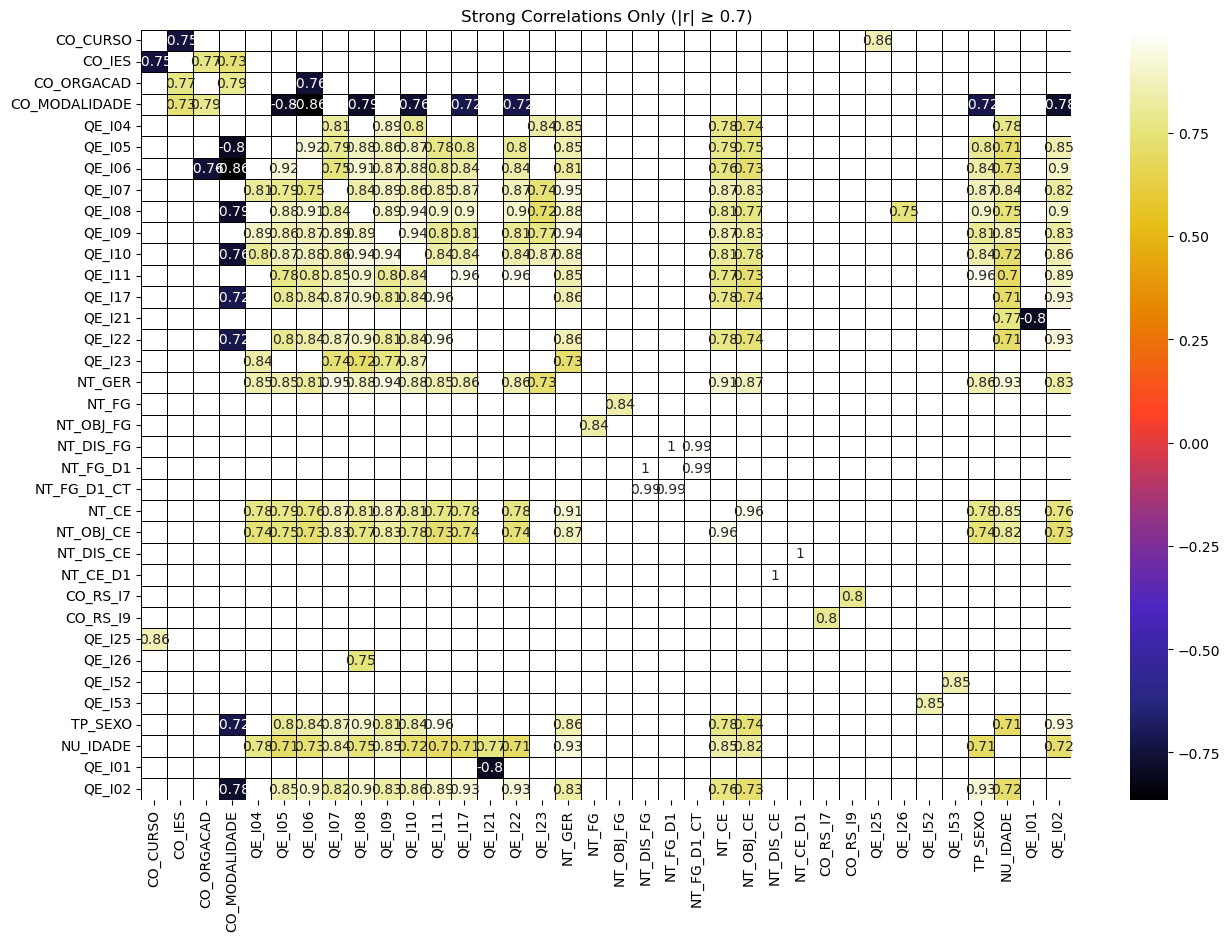

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas as colunas numéricas
numeric_features = df.select_dtypes(include=['int64', 'float64', 'int32']).columns

# Calcula a matriz de correlação
corr_matrix = df[numeric_features].corr()

# Aplica máscara para manter apenas correlações fortes
threshold = 0.7
strong_corr = corr_matrix[(np.abs(corr_matrix) >= threshold) & (corr_matrix != 1.0)]

# Remove colunas/linhas com todos os valores NaN (sem correlação forte)
strong_corr = strong_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Exibe o heatmap com linhas separando as células se houver correlações fortes
if not strong_corr.empty:
    plt.figure(figsize=(15, 10))
    sns.heatmap(strong_corr, cmap="CMRmap", annot=True, linewidths=0.5, linecolor='black')  # Linha separando células
    plt.title("Strong Correlations Only (|r| ≥ 0.7)")
    plt.show()
else:
    print("Não foram encontradas correlações fortes (|r| ≥ 0.7).")


### Gerar histograma para todas as colunas numéricas

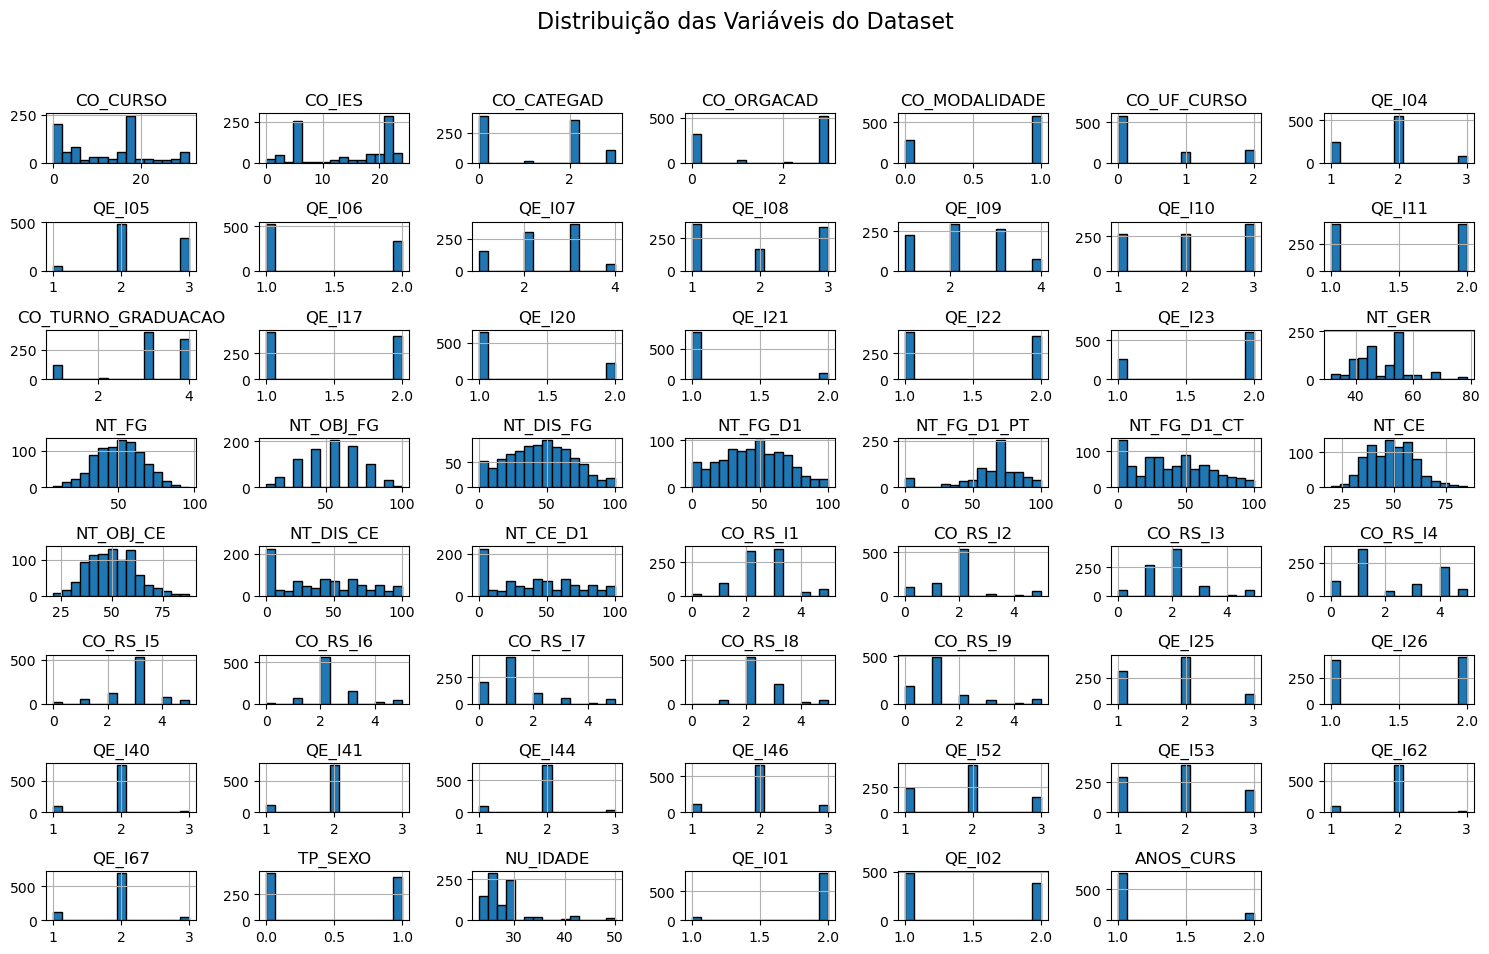

In [20]:
import matplotlib.pyplot as plt

# Gerar histograma para todas as colunas numéricas
fig = df.hist(figsize=(15, 10), bins=15, edgecolor='black')

# Adicionar um título geral ao conjunto de subgráficos
plt.suptitle("Distribuição das Variáveis do Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste para o título não sobrepor os gráficos
plt.show()


### Distribuição das Variáveis Categóricas (object) - Após tratamento não existem mais

In [21]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Selecionar apenas as colunas categóricas (object)
# categorical_cols = df.select_dtypes(include='object').columns

# # Definir o tamanho da grade
# n_cols = 3  # número de colunas de gráficos por linha
# n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
# axes = axes.flatten()

# for i, col in enumerate(categorical_cols):
#     sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
#     axes[i].set_title(f'Distribuição de {col}')
#     axes[i].tick_params(axis='x', rotation=45)

# # Remover subplots vazios
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# # Título geral e layout
# plt.suptitle("Distribuição das Variáveis Categóricas (object)", fontsize=20)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


## Pré-processamento

### Informações do dataset final

In [22]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

# Supondo que 'df' seja o seu DataFrame e 'ANOS_CURS' a coluna alvo
X = df.drop(columns=['ANOS_CURS'])
y = df['ANOS_CURS']

# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Especificando as colunas NÃO categóricas (as contínuas)
# Substitua esses nomes pelos reais do seu dataset
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG',
                  'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT', 'NT_CE', 'NT_OBJ_CE', 
                   'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT'] 

# Inferindo as colunas categóricas como sendo o complemento
categorical_column_names = [col for col in X_train.columns if col not in nao_categoricas]

# Pegando os índices das colunas categóricas
categorical_features_idx = [X_train.columns.get_loc(col) for col in categorical_column_names]

# Convertendo X_train para numpy array
X_train_array = X_train.values

# Aplicando SMOTENC apenas no treino
smote_nc = SMOTENC(categorical_features=categorical_features_idx, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train_array, y_train)

# Opcional: voltar para DataFrame
X_train = pd.DataFrame(X_resampled, columns=X_train.columns)
y_train = y_resampled.reset_index(drop=True)

# Corrigir tipos com base em X_test
for col in X_train.columns:
    X_train[col] = X_train[col].astype(X_test[col].dtype)


In [23]:
# # Aplicar o CatBoost

# #Instalando o CatBoost
# import sys
# !{sys.executable} -m pip install catboost


In [24]:
from catboost import CatBoostClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Criar e treinar o modelo CatBoost
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    early_stopping_rounds=20,
    verbose=0
)

model.fit(X_train, y_train, cat_features=categorical_features_idx)
y_pred = model.predict(X_test)

# Avaliar o modelo
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.91      0.91      0.91       226
           2       0.40      0.41      0.41        34

    accuracy                           0.84       260
   macro avg       0.66      0.66      0.66       260
weighted avg       0.84      0.84      0.84       260



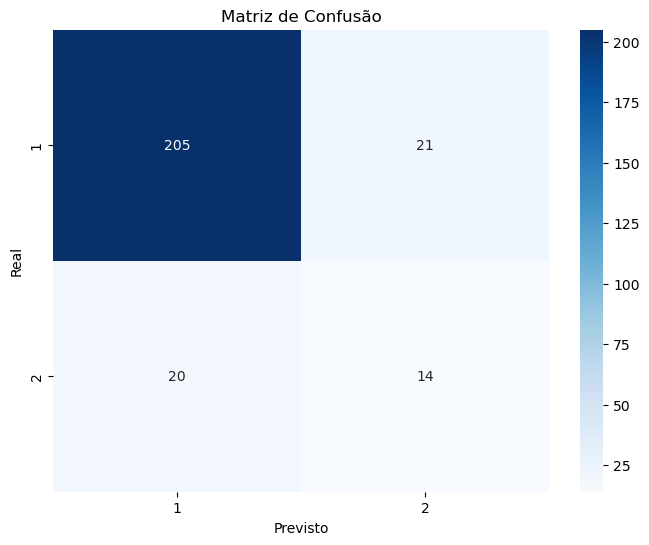

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenha as previsões do modelo
y_pred = model.predict(X_test)

# Gere a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exiba a matriz usando seaborn para uma visualização mais clara
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [26]:
df_corr = df.copy()
df_corr['ANOS_CURS'] = y  # Certifique-se que 'y' está no df
print(df_corr.corr(numeric_only=True)['ANOS_CURS'].sort_values(ascending=False))


ANOS_CURS             1.000000
CO_MODALIDADE         0.244738
CO_IES                0.164704
CO_ORGACAD            0.157447
CO_UF_CURSO           0.099538
QE_I01                0.092780
CO_RS_I3              0.055817
CO_TURNO_GRADUACAO    0.044608
CO_RS_I9              0.042841
CO_RS_I4              0.037566
CO_RS_I5              0.035293
CO_RS_I1              0.029561
CO_RS_I6              0.024082
QE_I41                0.019843
CO_RS_I8              0.009122
CO_RS_I7              0.007593
QE_I46               -0.011808
QE_I67               -0.012137
CO_RS_I2             -0.018406
QE_I52               -0.028308
CO_CATEGAD           -0.028315
QE_I44               -0.031387
QE_I53               -0.036709
NT_FG_D1_CT          -0.048859
QE_I40               -0.052431
NT_DIS_FG            -0.065361
NT_FG_D1             -0.065477
QE_I62               -0.069909
NT_DIS_CE            -0.069999
NT_CE_D1             -0.070090
QE_I20               -0.092590
NT_FG_D1_PT          -0.113179
QE_I21  

### Aplicar algoritmo kBest

In [27]:

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns

# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))


# categorical_cols = df.select_dtypes(include='object').columns

# # Supondo que sua variável alvo seja 'target' e as features estão no restante das colunas
# X = df.drop('ANOS_CURS', axis=1)  # Remova a coluna alvo
# y = df['ANOS_CURS']  # Variável alvo

# # Aplicando o SelectKBest com o teste chi2
# kbest = SelectKBest(score_func=chi2, k=10)  # Seleciona as 5 melhores variáveis

# # Ajustando o modelo e transformando as features
# X_kbest = kbest.fit_transform(X, y)

# # Visualizar as colunas selecionadas
# selected_columns = X.columns[kbest.get_support()]
# print(f'Colunas selecionadas: {selected_columns}')



## Aplicando PCA

In [28]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Codificação de variáveis categóricas
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns

# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# # Separando features e alvo
# X = df.drop('ANOS_CURS', axis=1)
# y = df['ANOS_CURS']

# # Padronização dos dados (necessária para PCA)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicando PCA para reduzir para 10 componentes
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

# # Exibir a variância explicada por cada componente
# print(f'Variância explicada por cada componente: {pca.explained_variance_ratio_}')
# print(f'Soma da variância explicada: {sum(pca.explained_variance_ratio_):.2f}')


### Aplicando o CatBoost sem balanceamento e com K-Best

In [29]:
#Instalando o CatBoost
# import sys
# !{sys.executable} -m pip install catboost


In [30]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# # Lista de variáveis selecionadas
# selected_cols = ['CO_CURSO', 'CO_IES', 'QE_I06', 'QE_I08', 'QE_I10', 'QE_I11', 'QE_I17',
#        'QE_I22', 'NU_IDADE', 'QE_I02']

# # Separar X e y
# X = df[selected_cols]
# y = df['ANOS_CURS']  # Substitua 'target' pelo nome real da sua variável alvo

# # Dividir treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

# # Criar e treinar o modelo CatBoost
# model = CatBoostClassifier(
#     iterations=500,
#     learning_rate=0.1,
#     depth=6,
#     eval_metric='Accuracy',
#     verbose=0
# )

# # Treinar o modelo
# model.fit(X_train, y_train, cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Todas as colunas são categóricas

# # Fazer previsões
# y_pred = model.predict(X_test)

# # Avaliar o modelo
# print(classification_report(y_test, y_pred))


In [31]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost")
# plt.show()


### CatBoost com SMOTE e K-Best

In [32]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import OrdinalEncoder
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# # Colunas selecionadas
# selected_cols = ['CO_CURSO', 'CO_IES', 'QE_I06', 'QE_I08', 'QE_I10', 'QE_I11', 'QE_I17',
#        'QE_I22', 'NU_IDADE', 'QE_I02']
# X = df[selected_cols]
# y = df['ANOS_CURS']

# # Codificar variáveis categóricas
# encoder = OrdinalEncoder()
# X_encoded = encoder.fit_transform(X)

# # Dividir dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y, test_size=0.3, random_state=42, stratify=y
# )

# # Modelo base
# catboost_model = CatBoostClassifier(verbose=0, eval_metric='Accuracy')

# # Grid de hiperparâmetros
# param_grid = {
#     'classifier__learning_rate': [0.1, 0.01, 0.001, 0.0001],
#     'classifier__iterations': [50, 100, 200, 300],
#     'classifier__depth': [2, 5, 10, 16]
# }

# # Pipeline com SMOTE e CatBoost
# pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=1, random_state=42)),
#     ('classifier', catboost_model)
# ])

# # Validação cruzada com KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com Cross-Validation
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Executar Grid Search
# grid_search.fit(X_train, y_train)

# # Melhor modelo
# best_model = grid_search.best_estimator_

# # Previsões no conjunto de teste
# y_pred = best_model.predict(X_test)

# # Resultados
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


In [33]:
# # Aplicar SMOTE separadamente para ver o balanceamento
# smote = SMOTE(k_neighbors=1, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # Mostrar informações sobre o balanceamento
# from collections import Counter
# print("Distribuição original:", Counter(y_train))
# print("Distribuição após SMOTE:", Counter(y_resampled))

# # Número de amostras geradas:
# num_generated = len(X_resampled) - len(X_train)
# print("Total de registros gerados pelo SMOTE:", num_generated)


In [34]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost com SMOTE")
# plt.show()


### Catboost com pca

In [35]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Pré-processamento
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# # Separar X e y
# X = df.drop('ANOS_CURS', axis=1)
# y = df['ANOS_CURS']

# # Padronizar os dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar PCA
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

# # Dividir treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca, y, test_size=0.3, random_state=42, stratify=y
# )

# # Criar e treinar o modelo CatBoost
# model = CatBoostClassifier(
#     iterations=500,
#     learning_rate=0.1,
#     depth=6,
#     eval_metric='Accuracy',
#     verbose=0
# )

# model.fit(X_train, y_train)

# # Fazer previsões
# y_pred = model.predict(X_test)

# # Avaliar o modelo
# print(classification_report(y_test, y_pred))


In [36]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão graficamente
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost")
# plt.show()


### CatBoost com SMOTE e PCA

In [37]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
# import pandas as pd

# # Codificação de variáveis categóricas
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# # Separar X e y
# X = df.drop('ANOS_CURS', axis=1)
# y = df['ANOS_CURS']

# # Padronização dos dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar PCA (antes da divisão para não aplicar fit em dados de teste)
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

# # Dividir dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca, y, test_size=0.3, random_state=42, stratify=y
# )

# # Modelo base
# catboost_model = CatBoostClassifier(verbose=0, eval_metric='Accuracy')

# # Grid de hiperparâmetros
# param_grid = {
#     'classifier__learning_rate': [0.1, 0.01, 0.001],
#     'classifier__iterations': [50, 100, 200],
#     'classifier__depth': [2, 5, 10]
# }

# # Pipeline com SMOTE e CatBoost (PCA já foi aplicado antes)
# pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=1, random_state=42)),
#     ('classifier', catboost_model)
# ])

# # Validação cruzada
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Treinar o modelo
# grid_search.fit(X_train, y_train)

# # Melhor modelo
# best_model = grid_search.best_estimator_

# # Prever no teste
# y_pred = best_model.predict(X_test)

# # Resultados
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


In [38]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Gerar a matriz de confusão
# cm = confusion_matrix(y_test, y_pred)

# # Exibir a matriz de confusão graficamente
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("MC do CatBoost com SMOTE")
# plt.show()


In [39]:
# # Aplicar SMOTE separadamente para ver o balanceamento
# smote = SMOTE(k_neighbors=1, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # Mostrar informações sobre o balanceamento
# from collections import Counter
# print("Distribuição original:", Counter(y_train))
# print("Distribuição após SMOTE:", Counter(y_resampled))

# # Número de amostras geradas:
# num_generated = len(X_resampled) - len(X_train)
# print("Total de registros gerados pelo SMOTE:", num_generated)


### Random Forest

In [40]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# # Codificação de variáveis categóricas
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include='object').columns
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# # Separar X e y
# X = df.drop('ANOS_CURS', axis=1)
# y = df['ANOS_CURS']

# # Padronização dos dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar PCA
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

# # Dividir dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pca, y, test_size=0.3, random_state=42, stratify=y
# )

# # Modelo base: Random Forest
# rf_model = RandomForestClassifier(random_state=42)

# # Grid de hiperparâmetros
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2],
#     'classifier__class_weight': ['balanced', None]  # Ajuste de pesos para lidar com desbalanceamento
# }

# # Pipeline com SMOTE e Random Forest
# pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=1, random_state=42)),
#     ('classifier', rf_model)
# ])

# # Validação cruzada com KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com Cross-Validation
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Treinando o modelo
# grid_search.fit(X_train, y_train)

# # Melhor modelo
# best_model = grid_search.best_estimator_

# # Previsões no conjunto de teste
# y_pred = best_model.predict(X_test)

# # Resultados
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
